In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## **Predicting the Chances of a Stroke**

#### **Introduction:**

Strokes are serious life-threatening medical conditions that happen when the blood supply to part of the brain is cut off. It is imperative that strokes are met with immediate treatment to prevent brain damage. According to the World Health Organization (WHO), strokes are the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. 

Our project intends to accurately predict the chances of stroke by examining multiple clinical values.

Stroke Prediction Dataset, the title of the dataset we chose for this project, was adapted from the Kaggle data scientist fedesoriano. The dataset provides ten clinical features for predicting strokes: gender, age, hypertension, heart_disease, ever_married, work_type, residence_type, avg_glucose_level, bmi, and smoking_status.

link to the dataset: (https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download)

#### **Preliminary Exploratory Data Analysis:**
**Reading and Tidying Data**

In [9]:
 #randomizes rows
set.seed(1234)

#reading dataset into R
stroke_data <- read_csv("data/stroke_data.csv")  |>

#removes N/A values in bmi column
#3832 - 3687 = 145 rows that have missing data in bmi column
filter(bmi != "N/A") |>

#turns bmi column into dbl (previously chr)
mutate(bmi = as.numeric(bmi))

#splits data into training and testing sets
stroke_split <- initial_split(stroke_data, prop = 0.75, strata = stroke) 
    stroke_train <- training(stroke_split)
    stroke_test <- testing(stroke_split)

stroke_train
 
   

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
22127,Female,18,0,0,No,Private,Urban,82.85,46.9,Unknown,0
14180,Female,13,0,0,No,children,Rural,103.08,18.6,Unknown,0
19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
44679,Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


**Summarized Data**

In [12]:
# the average glucose level of stroke/no stroke
stroke_train |> 
group_by(stroke) |>
summarize(avg_gluc = mean(avg_glucose_level))


# the average bmi of stroke/no stroke
stroke_train |> 
group_by(stroke) |>
summarize(avg_BMI = mean(bmi, na.rm = TRUE))
    

# the average age of stroke/no stroke
stroke_train |>
group_by(stroke) |>
summarize(avg_age = mean(age))


# the number of people for each smoking status of stroke/no stroke
stroke_train |>
group_by(stroke, smoking_status) |>
summarize(number_of_people = n())
    #we might not use smoking_status as a predictor variable; summarized statistics seem to contradict common sense


# the number of people with/without heart disease
stroke_train |>
group_by(stroke, heart_disease) |>
summarize(number_of_people = n())
    #we might not use heart_disease as a predictor variable; summarized statistics seem to contradict common sense

stroke,avg_gluc
<dbl>,<dbl>
0,104.0971
1,130.2590


stroke,avg_BMI
<dbl>,<dbl>
0,28.83380
1,30.32349


stroke,avg_age
<dbl>,<dbl>
0,41.89763
1,67.56627


`summarise()` has grouped output by 'stroke'. You can override using the
`.groups` argument.


stroke,smoking_status,number_of_people
<dbl>,<chr>,<int>
0,formerly smoked,570
0,never smoked,1338
0,smokes,527
0,Unknown,1080
1,formerly smoked,46
1,never smoked,65
1,smokes,31
1,Unknown,24


`summarise()` has grouped output by 'stroke'. You can override using the
`.groups` argument.


stroke,heart_disease,number_of_people
<dbl>,<dbl>,<int>
0,0,3362
0,1,153
1,0,136
1,1,30


**Visualization of Data**

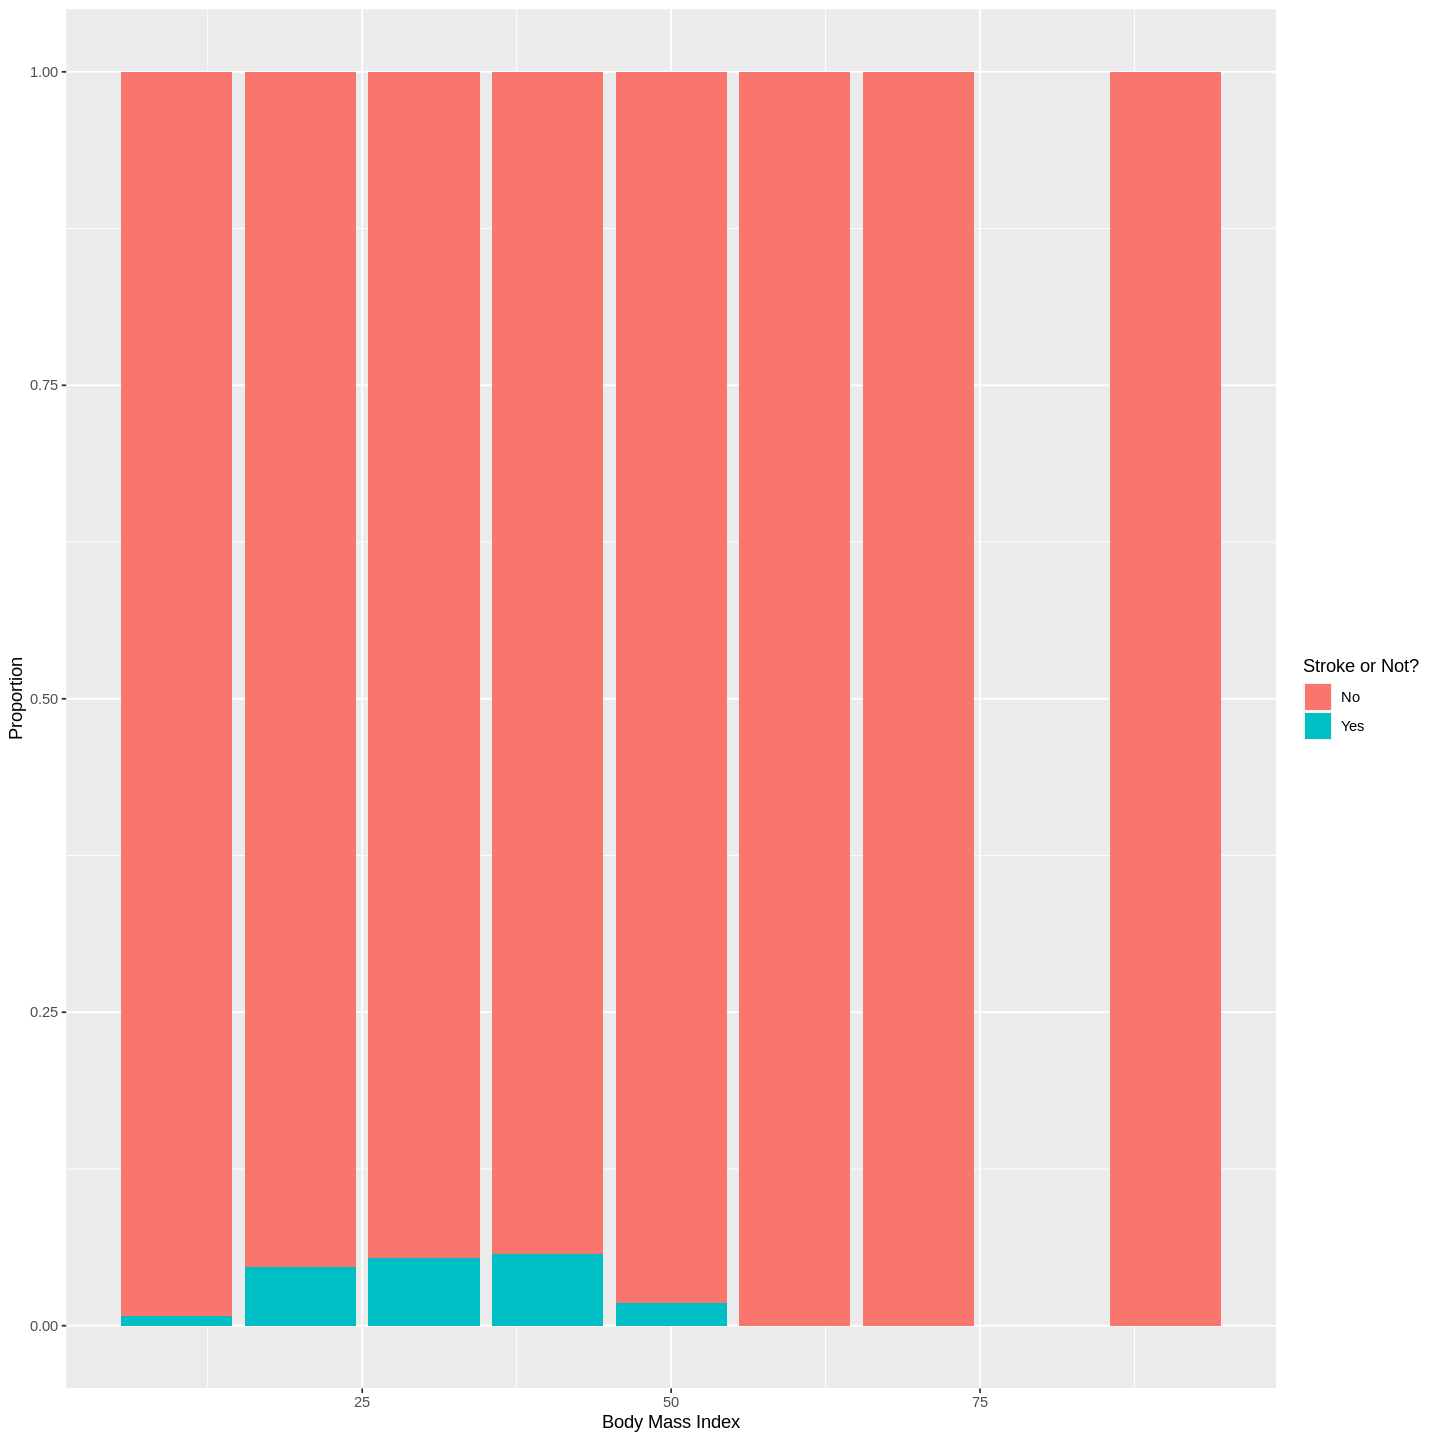

In [17]:
options(repr.plot.width=12, repr.plot.height=12)

# This is the frame that is only used for plotting
# It generalizes the bmi for plotting and convert stroke to char so that it can be used as the 'fill' argument.
stroke_train_for_plot <- stroke_train |>
    mutate(generalized_bmi = floor(floor(as.double(bmi))/10)*10) |>
    mutate(stroke_or_not = as.character(stroke))

# This bar graph visualizes the relationship between Body Mass Index and whether the person has a stroke or not
plot <- stroke_train_for_plot |>
    ggplot(aes(x = generalized_bmi, fill = stroke_or_not)) +
    geom_bar(position = 'fill') +
    labs(fill = 'Stroke or Not?', x = 'Body Mass Index', y = 'Proportion') +
    scale_fill_discrete(labels = c('No', 'Yes'))
plot

#### **Methods:**


We will first standardize the numerical variables and convert the categorized variables to numerical values so that we can quantify their effect on the prediction result and makes all of the variables contribute equally to the outcome. 

Then we will split the database into two parts: the training set and the testing set by the ratio of 3:1. We also need to make sure that the two parts of the database have approximately the same percentage of different types of variables.

Next, we will split the training set into 5 folds to apply cross-validation to choose the most suitable k-value with the highest accuracy.

Finally, we will train the model again using the k-value determined and the testing set to evaluate the accuracy by a confusion matrix.
In terms of visualizing the data, we will plot the data on a bar plot where the x-axis is age and the y-axis is whether or not the prediction is correct to measure our result visually.


#### **Expected outcomes and significance:**

There are too many variables for us to consider using all of them. If we were to expect outcomes, we would expect the following: individuals that are older, have a heart disease, have high bmi values, smoke regularly, and maintain high average glucose levels, are at most risk of a stroke.

The analysis of the Stroke Prediction Dataset can potentially provide insights into the risk factors associated with strokes. By examining multiple clinical features, the researchers can identify the most significant predictors of stroke occurrence, and develop a model that accurately predicts the likelihood of a stroke occurring in an individual.

The findings of such research can have significant implications for public health. Early detection and prevention can help reduce the number of fatalities associated with the condition. 

Analysis can also lead to future questions related to stroke prevention and treatment. For instance, the researchers can examine the effectiveness of existing stroke prevention measures and identify areas for improvement. Additionally, the findings can lead to the development of new treatment and prevention strategies that can further reduce the incidence of strokes.

#### **Word Count: 467**